In [1]:
#import ipywidgets as widgets
import numpy as np
from matplotlib import pyplot as plt
import scanpy as sc
import pandas as pd
import os

import scipy.sparse as ssp
    

data_path='bifur_StaticBC_data' # A relative path to save data. If not existed before, create a new one.
figure_path='bifur_StaticBC_figure' # A relative path to save figures. If not existed before, create a new one.
!mkdir -p $data_path
!mkdir -p $figure_path

In [2]:
import sys
new_path=os.getcwd()+"/.."
sys.path.append(new_path)
import cospar as CS

In [22]:
np.__version__

'1.19.4'

## Preprocessing

In order for this to work, it is mandatory that you provide 
* cell_by_feature_count_matrix (e.g., count matrix for scRNAseq)
* feature_id (e.g.,gene names)
* time_info

The clonal data is optional. If not provided, cospar generates the transition map based on time information only
* cell_by_clone_matrix

It is recommended that you also provide the following data, although we also provide preprocessing to generate them
* X_pca (pca matrixs)
* X_embedding (two-dimensional embedding)
* cell_state_annotation (cluster id for each cell)

### loading data

Download raw data from this link: 
*  https://kleintools.hms.harvard.edu/tools/downloads/cospar/bifur_adata_preprocessed.h5ad

and put it to the folder of data_path

Or use wget:

In [5]:
!wget https://kleintools.hms.harvard.edu/tools/downloads/cospar/bifur_adata_preprocessed.h5ad
!mv bifur_adata_preprocessed.h5ad $data_path

--2021-01-05 22:23:16--  https://kleintools.hms.harvard.edu/tools/downloads/cospar/bifur_adata_preprocessed.h5ad
Resolving kleintools.hms.harvard.edu (kleintools.hms.harvard.edu)... 134.174.159.103
Connecting to kleintools.hms.harvard.edu (kleintools.hms.harvard.edu)|134.174.159.103|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1559402 (1.5M)
Saving to: ‘bifur_adata_preprocessed.h5ad’

bifur_adata_preproc 100%[===================>]   1.49M  2.36MB/s    in 0.6s    

2021-01-05 22:23:17 (2.36 MB/s) - ‘bifur_adata_preprocessed.h5ad’ saved [1559402/1559402]



In [3]:
#data_path='lung_data_test' # A relative path to save data. If not existed before, create a new one.
#figure_path='lung_figure_test' # A relative path to save figures. If not existed before, create a new one.

#

adata_orig_0=sc.read(f'{data_path}/bifur_adata_preprocessed.h5ad')
data_des='bifur' # This is just a name to indicate this data. Will be used for saving the results. Can be arbitrary

    
clone_annot_orig=adata_orig_0.obsm['cell_by_clone_matrix']

X_embedding=adata_orig_0.obsm['X_umap']
state_annote_orig=adata_orig_0.obs['state_annotation'] # cluster id for each cell
X_pca_0=adata_orig_0.obsm['X_pca']

#data_des='bifur' # This is just a name to indicate this data. Will be used for saving the results. Can be arbitrary


### Initialize the adata structure

[Errno 17] File exists: 'bifur_StaticBC_data'
[Errno 17] File exists: 'bifur_StaticBC_figure'


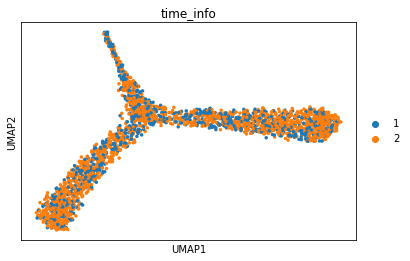

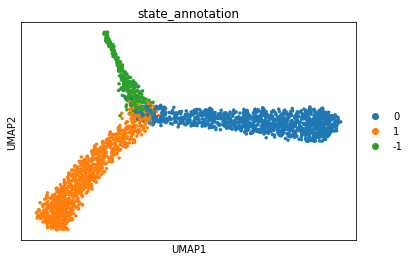

All time points: {'2', '1'}
Time points with clonal info: {'2', '1'}


In [4]:
#data_des='XXX' # This is just a name to indicate this data. Will be used for saving the results. Can be arbitrary

# ---------------- Mandatory information -------------------

# Feature matrix, with row in cell id, and column in feature id.
# For single-cell RNA seq data, the feature is gene expression. The feature matrix is the UMI count matrix.
# Used for selecting highly variable genes in constructing the HighVar_transition_map
# After the map is constructed, it is used for differential gene expression analysis
cell_by_feature_count_matrix=adata_orig_0.X  
                                    
                                    
# Feature IDs, for selecting highly variable features (genes), and DGE analysis
feature_id=adata_orig_0.var_names 


# time_info is just an annotation for each cell. 
# Typically, it contains the time information, in string data type, like 'Day27'
# However, it can also contain other sample_info, like 'GFP+_day27', and 'GFP-_day27'
# This is critical for map construction.
time_info=adata_orig_0.obs['time_info']



# The clonal data matrix, with the row in cell_id, and column in clone_id
# Here, the clone_id is just the barcode_id. And the same cell may carry different barcode_id 
# that are integrated into its genome at different time points in the process of differentiation.
# In the case of CRISPR experiments, the barcode is each distinguishable mutations introduced over time
cell_by_clone_matrix=clone_annot_orig


# ---------------- Optional information (if not provided, the pipeline creates them) -------------------

# Needed for construct KNN graph, for building the similarity matrix
# involved also in OT_transition_map computation, and for pseudo-time ording 
X_pca=X_pca_0 


# The two-dimensional embedding. It can be created with UMAP, or other methods like force-directed layout.
# It is used only for plotting after the transition map is created
X_emb=X_embedding


# state_annotation is the classification and annotation for each cell state.
# this will be used only after the map is created. So, it can be adjusted later
cell_state_annotation=state_annote_orig 



adata_orig=CS.tmap.initialize_input_adata_object(cell_by_feature_count_matrix,feature_id,time_info,
        cell_by_clone_matrix=cell_by_clone_matrix,
                X_pca=X_pca,X_emb=X_emb,state_annotation=cell_state_annotation,
                            data_path=data_path,figure_path=figure_path,data_des=data_des)

In [5]:
# # This creates all X_pca and embedding from scratch

# adata_orig=CS.tmap.initialize_input_adata_object(cell_by_feature_count_matrix,gene_names,time_info,cell_by_clone_matrix,
#                 X_pca=X_pca,X_emb=X_emb,data_path=data_path,figure_path=figure_path,data_des=data_des,min_gene_variability_pctl=80)

In [6]:
adata_orig.uns['data_des']

['bifur']

In [7]:
save_data=False
if save_data:
    print("Save pre-computed")
    data_des=adata_orig.uns['data_des'][0]
    #adata.uns['state_trajectory']={} # need to set to empty, otherwise, it does not work
    #adata.uns['fate_trajectory']={} # need to set to empty, otherwise, it does not work
    adata_orig.write_h5ad(f'{data_path}/{data_des}_adata_preprocessed.h5ad', compression='gzip')
    print(data_des)

### Plot selected clones

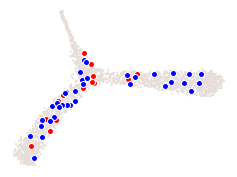

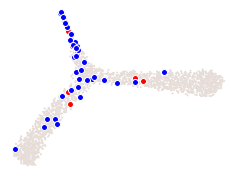

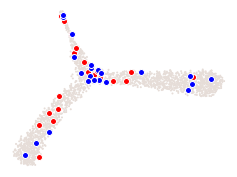

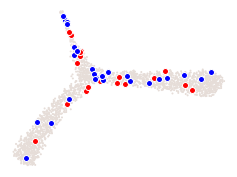

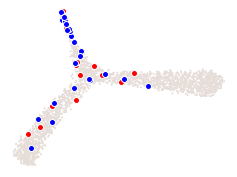

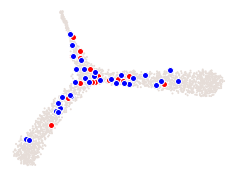

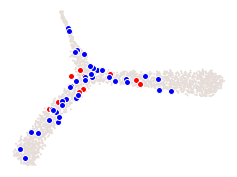

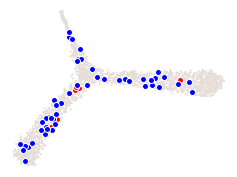

In [8]:
CS.pl.plot_clones(adata_orig,selected_clone_list=[1,2,3,4,5,6,7,8])

Current clone id: 0
Current clone id: 5
Current clone id: 10
Current clone id: 15
Current clone id: 20
Current clone id: 25
Current clone id: 30
Current clone id: 35
Current clone id: 40
Current clone id: 45
Current clone id: 50


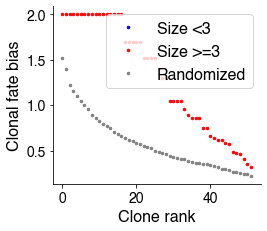

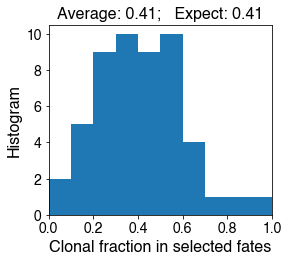

In [9]:
clonal_fate_bias,clone_id=CS.pl.plot_clonal_fate_bias(adata_orig,select_fate_cluster='1',N_resampling=100)

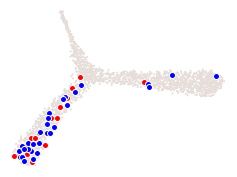

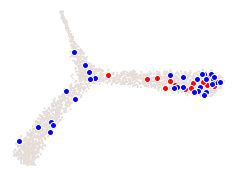

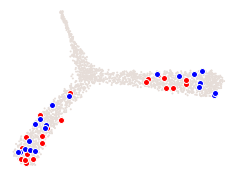

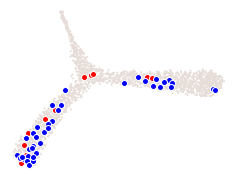

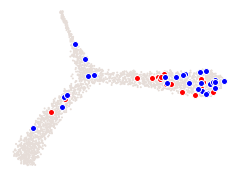

In [10]:
# plot top 5 bias clones
CS.pl.plot_clones(adata_orig,selected_clone_list=clone_id[:5])

## Map construction
Choose one of the following to run 
* *CoSpar - resampled clones*

* *CoSpar - One Time Clones*

### Inference Choice 1: CoSpar - resampled clones

*Purpose:* 
Compute transition map for re-sampled clonal data with both state and lineage information. We assume that the lineage information spans at least two time points.


In [16]:
#please read the documentation here
? CS.tmap.CoSpar_TwoTimeClones

In [14]:
print(f"All time points: {set(adata_orig.obs['time_info'])}")
print(f"Time points with clonal info: {set(adata_orig.uns['clonal_time_points'])}")

All time points: {'1', '2'}
Time points with clonal info: {'1', '2'}


Generate the transition map

-------Step 1: Select time points---------
Clonal cell fraction (day 1-2): 1.0
Clonal cell fraction (day 2-1): 1.0
Numer of cells that are clonally related -- day 1: 854  and day 2: 1620
Valid clone number 'FOR' post selection 52
Cell number=2474, Clone number=52
-------Step 2: Compute the full Similarity matrix if necessary---------
-------Step 3: Optimize the transition map recursively---------
---------Compute the transition map-----------
Compute similarity matrix: load existing data
Time elapsed:  0.013163089752197266
Time elapsed:  0.04620814323425293
Time elapsed:  0.011842012405395508
Time elapsed:  0.036116838455200195
Compute similarity matrix: load existing data
Time elapsed:  0.01459193229675293
Time elapsed:  0.028584003448486328
Time elapsed:  0.014203786849975586
Time elapsed:  0.054345130920410156
Compute similarity matrix: load existing data
Time elapsed:  0.010802984237670898
Time elapsed:  0.02205801010131836
Time elapsed:  0.013751029968261719
Time elapsed:  0.03276

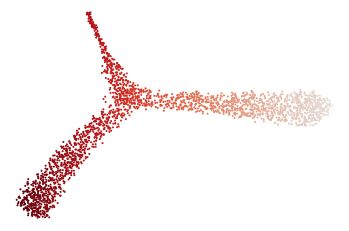

In [11]:
import time

t=time.time()
use_full_kernel=False 
noise_threshold=0.2 # 
adata=CS.tmap.CoSpar_TwoTimeClones(adata_orig,selected_clonal_time_points=['1','2'],SM_array=[10,10,10],
            CoSpar_KNN=20,noise_threshold=noise_threshold,demulti_threshold=noise_threshold,
             use_full_kernel=use_full_kernel,use_all_cells=False)
print(f'Used--time: {time.time()-t}')

Generate demultiplexed map within each clone (Optional, as this map has been generated already)

In [16]:
run_demultiplex=False
if run_demultiplex:
    demulti_threshold=0.2 # This threshold should be smaller, ass the map has been further smoothed to expand to more states.
    CS.tmap.CoSpar_TwoTimeClones_demultiplexing(adata,intra_clone_threshold=0,demulti_threshold=demulti_threshold)

### Alternative option: CoSpar - One Time Clones

*Purpose*: Infer transition map from scRNAseq data only using clones observed at the last time point. After initializing the map by either *OT* method or *HighVar* method, We jointly infer the likely clonal ancestors and the transition map between cell states in these two time points. 

In [15]:
# please read the documentation here
? CS.tmap.CoSpar_OneTimeClones

Parameters relevant for cell state selection: *initial_time_points, clonal_time_point, use_full_kernel, use_all_cells* 

Choose the initialization method, and set the corresponding parameters. 
* 'HighVar':  is faster and robust to batch effect. Related parameters: *HighVar_gene_pctl*
* 'OT': tend to be more accurate, but very slow and not reliable under batch effect. Related parameters: *OT_epsilon, OT_dis_KNN, OT_max_iter, OT_stopThr*

Parameters relevant for CoSpar itself: *SM_array,normalization_mode, CoSpar_KNN, noise_threshold, Clone_update_iter_N*

In [15]:
print(f"All time points: {set(adata_orig.obs['time_info'])}")
print(f"Time points with clonal info: {set(adata_orig.uns['clonal_time_points'])}")

All time points: {'2', '1'}
Time points with clonal info: {'2', '1'}


In [16]:
# compute_new, it will repeat the SM matrix construct
adata=CS.tmap.CoSpar_OneTimeClones(adata_orig,
    initial_time_points=['1'],clonal_time_point='2',Clone_update_iter_N=1,initialize_method='OT',SM_array=[10,10,10],
                        noise_threshold=0.2,compute_new=False)

-------------------------------New Start--------------------------------------------------
Current time point: 1
-----------Pre-processing and sub-sampling cells------------
----------------
Step 1: Use OT method for initialization
Compute new shortest path distance matrix
Finishing computing shortest-path distance, used time 2.9890849590301514
Compute new custon OT matrix
Finishing computing optial transport map, used time 17.627259016036987
----------------
Step 2: Jointly optimize the transition map and the initial clonal states!
Joint optimization that consider possibility of clonal overlap: v1
original clone shape: (2474, 52)
After excluding zero-sized clones: (2474, 52)
Sort clones by size (small to large)
Inferring early clonal states: current clone id 0
Inferring early clonal states: current clone id 50
---------Compute the transition map-----------
Compute similarity matrix: computing new; beta=0.1
Smooth round: 1
Time elapsed: 0.005558013916015625
Kernel matrix truncated (SM=

## Bridge steps

### Adjusting state_annotation (optional)

We combine marker gene expression and time information to select cell states for a particular fate

The changes are not confirmed until you set *confirm_change=True*


In [19]:
# #'NPC2','SFTPC','CLDN18','CEBPD','NAPSA','PRSS1','PGC','CXCL2'
# confirm_change=False
# CS.pl.refine_cell_state_annotation_by_marker_genes(adata,marker_genes=['NPC2','SFTPC'],gene_threshold=0.2,
#     selected_time_points=['4'],new_cluster_name='',add_neighbor_N=10,confirm_change=confirm_change)

Use leiden clustering for states at selected time points to generate cluster ID for cell states

The changes are not confirmed until you set *confirm_change=True*

In [17]:
# confirm_change=False
# CS.pl.refine_cell_state_annotation_by_leiden_clustering(adata,selected_time_points=['4'],leiden_resolution=0.5,
#                                     n_neighbors=5,confirm_change=confirm_change,cluster_name_prefix='T')

In [18]:
# confirm_change=False
# CS.pl.refine_cell_state_annotation_by_leiden_clustering(adata,selected_time_points=['4'],leiden_resolution=0.5,
#                                     n_neighbors=5,confirm_change=confirm_change,cluster_name_prefix='S')

### Save or load pre-computed maps

In [12]:
save_data=True
if save_data:
    CS.tmap.save_map(adata)
    
load_data=False
if load_data:
    
    #data_des='bifur_TTC_Timet*1*2'
    data_des='bifur_TwoTimeClone_t*1*2'
    data_des='bifur_OneTimeClone_t*1*2'
    
    print(f"Load data: data_des='{data_des}'")
    adata=sc.read(f'{data_path}/{data_des}_adata_with_transition_map.h5ad')


Saved file: data_des='bifur_TwoTimeClone_t*1*2'


In [13]:
adata

AnnData object with n_obs × n_vars = 2474 × 50
    obs: 'state_annotation', 'time_info'
    uns: 'data_path', 'figure_path', 'clonal_cell_id_t1', 'clonal_cell_id_t2', 'Tmap_cell_id_t1', 'Tmap_cell_id_t2', 'multiTime_cell_id_t1', 'multiTime_cell_id_t2', 'proportion', 'sp_idx', 'data_des', 'transition_map', 'demulti_transition_map', 'state_trajectory', 'fate_trajectory', 'fate_map'
    obsm: 'X_pca', 'X_umap', 'cell_by_clone_matrix'

Directly access the maps etc.

In [14]:
export_variables=True
if export_variables:
    transition_map=adata.uns['transition_map']
    #demultiplexed_map=adata.uns['demultiplexed_map']
    state_annote_0=adata.obs['state_annotation']
    Tmap_cell_id_t1=adata.uns['Tmap_cell_id_t1'] # initial states for the transition map
    Tmap_cell_id_t2=adata.uns['Tmap_cell_id_t2'] # later states for the transition map
    x_emb=adata.obsm['X_umap'][:,0]
    y_emb=adata.obsm['X_umap'][:,1]
    data_des=adata.uns['data_des'][0]
    time_info=np.array(adata.obs['time_info'])

## Plotting

There are some common parameters

* used_map_name: *'transition_map'*. If existing, also *'demultiplexed_map', 'OT_transition_map', 'HighVar_transition_map'*
    
* selected_fates: selected fate clusters for things like fate map construction, DGE analysis etc. The *selected_fates* allows nested structure, e.g., *selected_fates=[['0','2'],'1']* means combined cluster '0-2' and cluster '1'
    
* map_backwards: *True*, assuming that the *selected_fates* are cell states belonging to later time points (t2), and map for the initial cell states; *False*, map from early states to later states.
    
* plot_time_points: select states at given time points for the analysis
    
For more information, use *'? function_name'* to read the documentation.



### Transition profiles for single cells

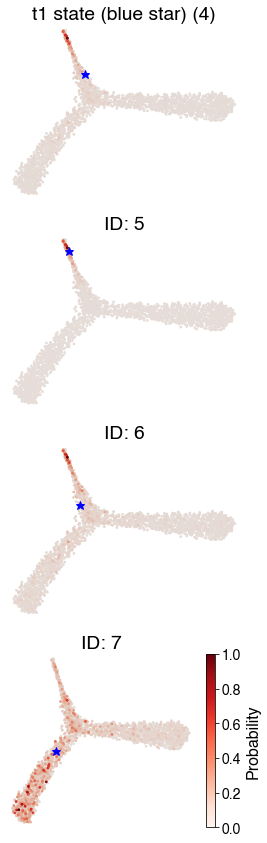

In [15]:
selected_state_id_list=[4,5,6,7]
map_backwards=False

CS.pl.plot_single_cell_transition_probability(adata,selected_state_id_list=selected_state_id_list,
                                    used_map_name='transition_map',map_backwards=map_backwards)

In [16]:
adata

AnnData object with n_obs × n_vars = 2474 × 50
    obs: 'state_annotation', 'time_info'
    uns: 'data_path', 'figure_path', 'clonal_cell_id_t1', 'clonal_cell_id_t2', 'Tmap_cell_id_t1', 'Tmap_cell_id_t2', 'multiTime_cell_id_t1', 'multiTime_cell_id_t2', 'proportion', 'sp_idx', 'data_des', 'transition_map', 'demulti_transition_map', 'state_trajectory', 'fate_trajectory', 'fate_map', 'available_map'
    obsm: 'X_pca', 'X_umap', 'cell_by_clone_matrix'

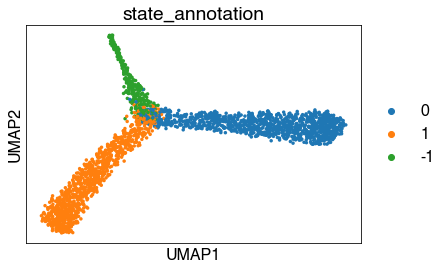

In [17]:
sc.pl.umap(adata,color='state_annotation')

### Fate map

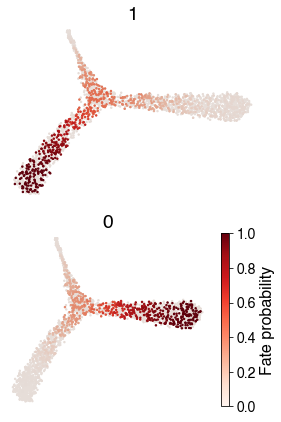

In [18]:
# Transition_map is generated by running CoSpar_OneTimeClones
map_backwards=True
CS.pl.plot_fate_map(adata,selected_fates=['1','0'],
               used_map_name='transition_map',map_backwards=map_backwards,plot_target_state=False,plot_fate_bias=False)

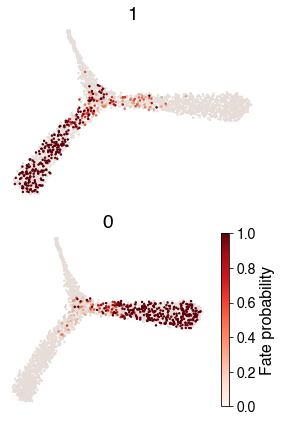

In [19]:
# OT_transition_map is generated by running CoSpar_OneTimeClones
map_backwards=True
CS.pl.plot_fate_map(adata,selected_fates=['1','0'],
               used_map_name='demulti_transition_map',map_backwards=map_backwards,plot_target_state=False,plot_fate_bias=False)

### Binary fate choice

Map backwards. Selected_fates should be cell clusters at later time points

(854, 2)


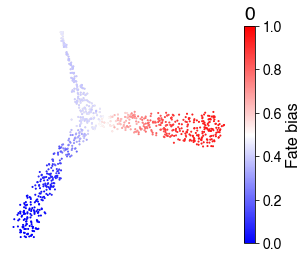

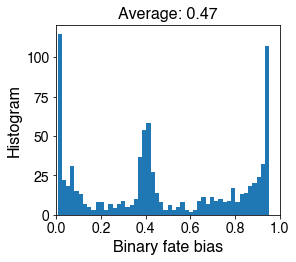

In [20]:
map_backwards=True 
CS.pl.plot_binary_fate_choice(adata,selected_fates=['0','1'],used_map_name='transition_map',
            plot_time_points=[],include_target_states=False,map_backwards=map_backwards,sum_fate_prob_thresh=0)

## Apply the naive method
Assume uniform transition within the same clone

(854, 2)


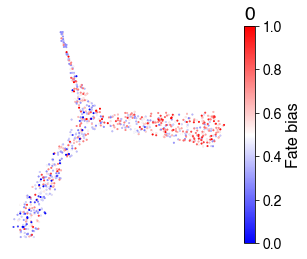

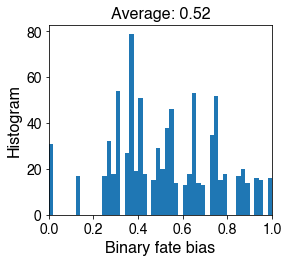

In [21]:
map_backwards=True 

CS.tmap.compute_naive_map(adata)

CS.pl.plot_binary_fate_choice(adata,selected_fates=['0','1'],used_map_name='naive_transition_map',
            plot_time_points=[],include_target_states=False,map_backwards=map_backwards,sum_fate_prob_thresh=0.4)